In [1]:
from __future__ import unicode_literals
from nltk.corpus import stopwords
from nltk import stem,pos_tag
import re
from collections import Counter
import numpy as np
from sklearn.cluster import KMeans
%pylab inline
from textblob import TextBlob
from sklearn.metrics import silhouette_score,confusion_matrix,accuracy_score,roc_curve
import pandas as pd
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize,Normalizer
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
import ftfy
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from seaborn import lmplot
import os  # for os.path.basename
import matplotlib as mpl
from sklearn.manifold import MDS,TSNE
%pylab inline
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD,PCA,NMF
from sklearn.pipeline import make_pipeline
from sklearn.decomposition.online_lda import LatentDirichletAllocation
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


/Users/onion8/miniconda3/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['stem']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Populating the interactive namespace from numpy and matplotlib


In [2]:
df=pd.read_csv('dataset/test.csv',encoding='utf-8')

In [5]:
data = df[['Business Description']]

In [7]:
rawdata=data

In [6]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

/Users/onion8/miniconda3/lib/python2.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [8]:
rawdata['Business Description']

0       024 Pharma, Inc. provides healthcare products ...
1       1-800-Flowers.com, Inc., together with its sub...
2       12 Retech Corporation, through its subsidiarie...
3       1347 Property Insurance Holdings, Inc., throug...
4       1847 Holdings LLC, through its subsidiaries, p...
5       1867 Western Financial Corporation, through it...
6       1mage Software Inc operates in the technology ...
7       1PM Industries, Inc. provides consulting servi...
8       1st Capital Bank provides various banking prod...
9       1st Colonial Bancorp, Inc. operates as the ban...
10      1st Constitution Bancorp operates as the bank ...
11      1st NRG Corp. explores, develops, produces, an...
12      1st Prestige Wealth Management provides wealth...
13      1st Source Corporation operates as the bank ho...
14      1ST SUMMIT BANCORP of Johnstown, Inc. operates...
15      RM Investors, Inc. supplies fruits and vegetab...
16      2050 Motors, Inc., a development stage company...
17      22nd C

In [9]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['Inc.', 'Company', 'Corporation','inc','inc.'])

In [12]:
# Convert to list
data = rawdata['Business Description'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]



pprint(data[:1])

[u'024 Pharma, Inc. provides healthcare products worldwide. Its products include vitamin and mineral supplements; stress release, joint, heart health, and weight-loss products; and skin care, hair, and anti-aging products. The company was formerly known as B Green Innovations, Inc. and changed its name to 024 Pharma, Inc. in October 2016. 024 Pharma, Inc. was incorporated in 2004 and is based in West Palm Beach, Florida.']


In [13]:
def sent_to_words(sentences):
    for sentence in sentences:
#         sentence = list(sentence)
#         sentence.append([x.encode('utf-8') for x in sentence])
        sentence = sentence.encode('utf-8')
        #print(sentence.encode('utf-8'))
        yield((gensim.utils.simple_preprocess(str(sentence), deacc=True)))
 # deacc=True removes punctuations

data_words=list(sent_to_words(data))

In [14]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

[u'pharma', u'inc', u'provides', u'healthcare', u'products', u'worldwide', u'its', u'products', u'include', u'vitamin', u'and', u'mineral', u'supplements', u'stress', u'release', u'joint', u'heart', u'health', u'and', u'weight_loss', u'products', u'and', u'skin', u'care', u'hair', u'and', u'anti_aging', u'products', u'the', u'company', u'was', u'formerly_known', u'as', u'green', u'innovations', u'inc', u'and', u'changed', u'its', u'name', u'to', u'pharma', u'inc', u'in', u'october', u'pharma', u'inc', u'was', u'incorporated', u'in', u'and', u'is', u'based', u'in', u'west_palm_beach_florida']


In [16]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [17]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)


# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])


# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

# for dg in data_words_bigrams:
#     dg=[x.decode('utf-8') for x in dg]
#     dw_bigram.append(dg)
    

[[u'pharma', u'provide', u'healthcare', u'product', u'worldwide', u'product', u'include', u'vitamin', u'mineral', u'supplement', u'stress', u'release', u'joint', u'heart', u'health', u'weight_loss', u'product', u'skin', u'care', u'hair', u'anti_aging', u'product', u'company', u'green', u'innovation', u'change', u'name', u'pharma', u'october', u'pharma', u'incorporate', u'base', u'west_palm', u'beach_florida']]


In [18]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 3), (19, 4), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1)]]


In [19]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(u'anti_aging', 1),
  (u'base', 1),
  (u'beach_florida', 1),
  (u'care', 1),
  (u'change', 1),
  (u'company', 1),
  (u'green', 1),
  (u'hair', 1),
  (u'health', 1),
  (u'healthcare', 1),
  (u'heart', 1),
  (u'include', 1),
  (u'incorporate', 1),
  (u'innovation', 1),
  (u'joint', 1),
  (u'mineral', 1),
  (u'name', 1),
  (u'october', 1),
  (u'pharma', 3),
  (u'product', 4),
  (u'provide', 1),
  (u'release', 1),
  (u'skin', 1),
  (u'stress', 1),
  (u'supplement', 1),
  (u'vitamin', 1),
  (u'weight_loss', 1),
  (u'west_palm', 1),
  (u'worldwide', 1)]]

In [34]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=32, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [35]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(23,
  u'0.000*"wengen" + 0.000*"lawson" + 0.000*"andean" + 0.000*"emeaa" + 0.000*"iberian" + 0.000*"laureate" + 0.000*"sylvan" + 0.000*"mmwave" + 0.000*"laxai" + 0.000*"plainfield"'),
 (8,
  u'0.006*"fraud_prevention" + 0.000*"sylvan" + 0.000*"uhd" + 0.000*"andean" + 0.000*"emeaa" + 0.000*"iberian" + 0.000*"laureate" + 0.000*"lawson" + 0.000*"wengen" + 0.000*"laxai"'),
 (31,
  u'0.142*"cancer" + 0.090*"human" + 0.051*"blood" + 0.045*"medicine" + 0.038*"anti" + 0.032*"surgery" + 0.031*"heart" + 0.030*"prevent" + 0.022*"adult" + 0.020*"biotech"'),
 (7,
  u'0.059*"module" + 0.052*"africa" + 0.043*"middle_east" + 0.042*"asia_pacific" + 0.041*"series" + 0.038*"processor" + 0.037*"europe" + 0.035*"signal" + 0.034*"original_equipment" + 0.031*"wire"'),
 (20,
  u'0.158*"nevada" + 0.092*"usa" + 0.090*"las_vegas" + 0.074*"transfer" + 0.045*"tennessee" + 0.038*"north_carolina" + 0.030*"top" + 0.025*"iron" + 0.019*"result" + 0.015*"sound"'),
 (2,
  u'0.079*"assembly" + 0.068*"specific" + 0.062*"

In [36]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

(u'\nPerplexity: ', -15.462186059669284)
(u'\nCoherence Score: ', 0.4757341931159688)


In [37]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
16     21.896847        1       1  0.329734 -0.189386
29     10.753078        1       2  0.304887  0.022869
17      8.421264        1       3  0.257593  0.102253
5       7.965384        1       4  0.228304  0.163461
30      7.196625        1       5  0.239647  0.160001
11      6.169342        1       6  0.186049 -0.347020
25      5.861608        1       7  0.228921  0.178033
14      3.059638        1       8  0.097034 -0.223258
22      2.851379        1       9  0.026590 -0.005093
26      2.575371        1      10  0.059330  0.114296
27      2.397911        1      11  0.051096 -0.065065
18      2.354675        1      12  0.040816 -0.000090
12      2.054959        1      13  0.046488  0.091941
4       1.971282        1      14  0.069561 -0.013498
28      1.689789        1      15  0.029352  0.034969
0       1.645554        1      16 -0.053606 -0.038530
9       1.526668        1      17 -0.016621 -0.036355
21      1.278948        1      18 -0.043960 -0.000986
15      1.232783        1      19 -0.048021 -0.016647
1       1.143013        1      20 -0.089941 -0.001081
3       0.802420        1      21 -0.133278 -0.001578
19      0.747354        1      22 -0.090776 -0.007097
13      0.675058        1      23 -0.119180  0.011496
31      0.656282        1      24 -0.160924  0.007340
10      0.595534        1      25 -0.156585  0.001217
7       0.579698        1      26 -0.150308  0.028785
24      0.575329        1      27 -0.162068  0.003112
6       0.470494        1      28 -0.148022  0.000148
2       0.451390        1      29 -0.177148  0.004245
20      0.387662        1      30 -0.173935  0.003475
8       0.007586        1      31 -0.235378  0.009010
23      0.005071        1      32 -0.235652  0.009033, topic_info=      Category          Freq            Term         Total  loglift  logprob
term                                                                        
193    Default  18177.000000         service  18177.000000  30.0000  30.0000
6969   Default  28176.000000         company  28176.000000  29.0000  29.0000
2801   Default  16403.000000         product  16403.000000  28.0000  28.0000
901    Default   4301.000000      technology   4301.000000  27.0000  27.0000
27302  Default   5993.000000            loan   5993.000000  26.0000  26.0000
12109  Default   7803.000000            base   7803.000000  25.0000  25.0000
24448  Default   4039.000000            name   4039.000000  24.0000  24.0000
19155  Default   5853.000000          system   5853.000000  23.0000  23.0000
22820  Default   2804.000000          energy   2804.000000  22.0000  22.0000
13023  Default   4960.000000        solution   4960.000000  21.0000  21.0000
4379   Default   8668.000000         operate   8668.000000  20.0000  20.0000
13675  Default  10260.000000         provide  10260.000000  19.0000  19.0000
28566  Default   2263.000000         holding   2263.000000  18.0000  18.0000
29020  Default   5262.000000        business   5262.000000  17.0000  17.0000
19203  Default   4746.000000         segment   4746.000000  16.0000  16.0000
11388  Default   3219.000000          change   3219.000000  15.0000  15.0000
29978  Default   5946.000000           state   5946.000000  14.0000  14.0000
21246  Default   4568.000000      management   4568.000000  13.0000  13.0000
28232  Default   2381.000000         network   2381.000000  12.0000  12.0000
5813   Default   6385.000000      subsidiary   6385.000000  11.0000  11.0000
21100  Default   4321.000000      commercial   4321.000000  10.0000  10.0000
18549  Default   7996.000000           found   7996.000000   9.0000   9.0000
19827  Default   2100.000000        property   2100.000000   8.0000   8.0000
3036   Default   3851.000000         develop   3851.000000   7.0000   7.0000
11770  Default   2169.000000       treatment   2169.000000   6.0000   6.0000
28450  Default   2671.000000  formerly_kno

In [40]:
mallet_path = '/Users/onion8/Downloads/utilities/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=32, id2word=id2word)

In [41]:
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(24,
  [(u'product', 0.06374388718298647),
   (u'company', 0.025929716820197884),
   (u'base', 0.019959058341862845),
   (u'industry', 0.017002160809735017),
   (u'market', 0.015182531559194815),
   (u'produce', 0.013988399863527807),
   (u'natural', 0.013874673035369043),
   (u'cannabis', 0.011770726714431934),
   (u'sell', 0.011258955987717503),
   (u'green', 0.008984419424542249)]),
 (4,
  [(u'product', 0.29394907968698336),
   (u'company', 0.07803372644108894),
   (u'include', 0.06728755648627796),
   (u'market', 0.05406150115727984),
   (u'comprise', 0.02722363055218781),
   (u'offer', 0.025956133583158823),
   (u'sell', 0.02551526507219222),
   (u'found', 0.018902237407693156),
   (u'distributor', 0.018681803152209853),
   (u'headquartered', 0.017910283258018297)]),
 (21,
  [(u'service', 0.11294416243654823),
   (u'financial', 0.060279187817258884),
   (u'management', 0.057695794053662076),
   (u'investment', 0.04110768672951414),
   (u'provide', 0.035668963016678754),
   (u'off

In [42]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [27]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

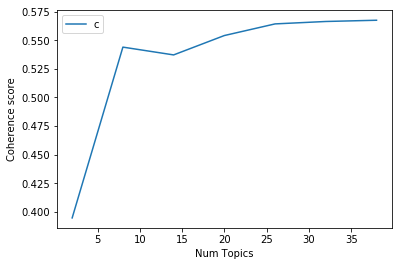

In [28]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [29]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

(u'Num Topics =', 2, u' has Coherence Value of', 0.3947)
(u'Num Topics =', 8, u' has Coherence Value of', 0.544)
(u'Num Topics =', 14, u' has Coherence Value of', 0.5372)
(u'Num Topics =', 20, u' has Coherence Value of', 0.5542)
(u'Num Topics =', 26, u' has Coherence Value of', 0.5643)
(u'Num Topics =', 32, u' has Coherence Value of', 0.5665)
(u'Num Topics =', 38, u' has Coherence Value of', 0.5675)


In [44]:
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(16,
  u'0.053*"food" + 0.036*"product" + 0.024*"beverage" + 0.023*"restaurant" + 0.020*"brand" + 0.020*"sell" + 0.017*"market" + 0.014*"distribute" + 0.014*"offer" + 0.011*"produce"'),
 (22,
  u'0.293*"product" + 0.128*"include" + 0.123*"company" + 0.059*"comprise" + 0.057*"offer" + 0.047*"provide" + 0.035*"found" + 0.034*"headquartered" + 0.024*"line" + 0.023*"addition"'),
 (19,
  u'0.095*"loan" + 0.048*"account" + 0.044*"banking" + 0.038*"bank" + 0.036*"credit" + 0.036*"deposit" + 0.030*"commercial" + 0.029*"business" + 0.023*"saving" + 0.019*"check"'),
 (23,
  u'0.075*"product" + 0.030*"home" + 0.025*"construction" + 0.022*"building" + 0.019*"offer" + 0.018*"sell" + 0.017*"commercial" + 0.016*"market" + 0.016*"light" + 0.016*"include"'),
 (25,
  u'0.063*"solution" + 0.057*"software" + 0.031*"application" + 0.027*"datum" + 0.027*"platform" + 0.021*"enterprise" + 0.021*"cloud" + 0.020*"enable" + 0.016*"information" + 0.015*"manage"'),
 (15,
  u'0.091*"holding" + 0.061*"operate" + 0.

In [45]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.tail(15)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
8410,8410,30.0,0.2132,"oil, energy, gas, texas, natural_gas, approxim...",Whiting USA Trust II holds a term net profits ...
8411,8411,1.0,0.3245,"network, communication, mobile, internet, wire...","WideOpenWest, Inc. operates as a cable operato..."
8412,8412,3.0,0.0982,"medium, digital, marketing, content, video, on...",Wikisoft Corp. provides online gaming solution...
8413,8413,19.0,0.3150,"loan, account, banking, bank, credit, deposit,...","William Penn Bancorp, Inc. operates as the hol..."
8414,8414,30.0,0.4530,"oil, energy, gas, texas, natural_gas, approxim...",Williams Partners L.P. operates as an energy i...
8415,8415,17.0,0.0887,"company, base, new_york, corp, found, business...","Williamsville Sears Management, Inc. does not ..."
8416,8416,0.0,0.0975,"insurance, financial, investment, service, man...","Wins Finance Holdings Inc., through its subsid..."
8417,8417,10.0,0.1361,"system, security, design, provide, support, ma...","Wrap Technologies, Inc. develops security prod..."
8418,8418,29.0,0.1149,"water, energy, fuel, industry, industrial, pla...","XcelPlus International, Inc. distributes chemi..."
8419,8419,17.0,0.1806,"company, base, new_york, corp, found, business...","Yacht Finders, Inc. does not have significant ..."


In [46]:

sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5352,"insurance, financial, investment, service, man...",Cincinnati Financial Corporation provides prop...
1,1.0,0.4772,"network, communication, mobile, internet, wire...","Ooma, Inc. provides communications solutions a..."
2,2.0,0.4455,"service, management, solution, provide, paymen...","Resources Connection, Inc. provides business c..."
3,3.0,0.5301,"medium, digital, marketing, content, video, on...","Viacom, Inc. operates media brands that create..."
4,4.0,0.5505,"health, care, healthcare, provide, medical, ce...","WellCare Health Plans, Inc. provides managed c..."
